In [2]:
import pandas as pd
import math as mth
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime


import statsmodels.api as sm
from numpy.random import default_rng
from scipy import signal
from sklearn.decomposition import PCA

In [3]:

def contaminante_filtro(strcont,contaminante,f_inicio,f_final,date_filepath,date_columna):
    df12 = pd.read_csv(strcont)
    

    
    df12= df12[['Date',contaminante]]
    f_inicio = pd.to_datetime(f_inicio)
    f_final = pd.to_datetime(f_final)
    df12['Date'] = pd.to_datetime(df12['Date'])
    df12=df12.loc[(df12['Date'] >= f_inicio)&((df12['Date'] <= f_final))]
    df12 = df12.reset_index()
    df12=df12.sort_values(by='Date',ignore_index=True)
    
    suma = 0    
    c = 0
    for i in range(df12.shape[0]):
        if df12.loc[i,contaminante] == '-' or pd.isnull(df12.loc[i,contaminante]) == True or df12.loc[i,contaminante] == '_' or df12.loc[i,contaminante] =='ND' :
            continue
        else:
            #print(i,df12.loc[i,contaminante])
            suma = float(df12.loc[i,contaminante])+suma
            c+=1
            
    media = suma /c
    print(media)
            
    for i in range(df12.shape[0]):
        if df12.loc[i,contaminante] == '-' or  pd.isnull(df12.loc[i,contaminante]) == True or df12.loc[i,contaminante] == '_' or  df12.loc[i,contaminante] =='ND':
            df12.loc[i,contaminante] = media
    df12[contaminante]= df12[contaminante].astype(float)
    
    date12 = pd.read_csv(date_filepath)
    date12[date_columna] = pd.to_datetime(date12[date_columna])
    date12=date12.sort_values(by=date_columna,ignore_index=True)
            
   
    lcont12 = []
    suma = df12.loc[0,contaminante]
    h = 1
    c = 0
    for j in range(df12.shape[0]):
        if j == df12.shape[0]-1:
            
            if df12.loc[j,'Date'] != df12.loc[j-1,'Date']:
                lcont12.append(df12.loc[j,contaminante])
            else:
                res=suma/h
                lcont12.append(res)
            continue
        elif df12.loc[j,'Date'] != date12.loc[c,date_columna]:
            
            while df12.loc[j,'Date'] != date12.loc[c,date_columna]:
                #print('bucle primero',df12.loc[j,'Date'], date12.loc[c,date_columna])
                c+=1
                lcont12.append(media)
            
                
        elif df12.loc[j,'Date'] == date12.loc[c,date_columna]:
            if df12.loc[j,'Date'] == df12.loc[j+1,'Date']:
                suma = df12.loc[j+1,contaminante]+suma
                h+=1
            elif df12.loc[j,'Date'] != df12.loc[j+1,'Date']:
                #print('diferencia',df12.loc[j+1,'Date'])
                res=suma/h
                lcont12.append(res)
                h=1
                suma =df12.loc[j+1,contaminante]
                c+=1
                while df12.loc[j+1,'Date'] != date12.loc[c,date_columna]:
                    #print('segundo  while',df12.loc[j+1,'Date'], date12.loc[c,date_columna])
                    c+=1
                    lcont12.append(media)
                    
            
            
    print('lista de contaminantes:',len(lcont12))
    
    if 31<len(lcont12)<365:
        for i in range(365-len(lcont12)):
            lcont12.append(media)
            
    l_media = []
    for i in range(5):
        l_media.append(media)
        
            
            

    return lcont12,l_media


In [4]:
def enfermedades_filtro(año,edad_i,edad_f,fecha_i,fecha_f,municipio,date_columna,date_filepath,enf_clave):
    enf12 = pd.read_csv(año)
    
    enf12['EDAD']=enf12['EDAD'].astype(float)
    enf12['MUNIC']=enf12['MUNIC'].astype(float)
    enf12['AFECPRIN']=enf12['AFECPRIN'].astype(str)   
    
    enf12=enf12.loc[enf12['MUNIC'] == municipio]
    enf12=enf12.loc[(enf12['EDAD'] >= edad_i) & (enf12['EDAD'] <= edad_f )]
    
    
    enf12['INGRE'] = pd.to_datetime(enf12['INGRE'], errors = 'coerce')
    enf12=enf12.sort_values(by='INGRE',ignore_index=True)
    
    fecha_i= pd.to_datetime(fecha_i)
    fecha_f = pd.to_datetime(fecha_f)
    enf12=enf12.loc[(enf12['INGRE'] >= fecha_i)&(enf12['INGRE'] <= fecha_f)]
    enf12=enf12.reset_index() 
    
    for a in range(enf12.shape[0]):
        if isinstance(enf12.loc[a,'AFECPRIN'],str) == False :
            enf12=enf12.drop(a, axis=0)
            
    if enf_clave == 'JI' or enf_clave == 'IJ':
        enf12=enf12.loc[(enf12["AFECPRIN"].str.contains('I')) | (enf12["AFECPRIN"].str.contains('J'))]
    elif enf_clave == 'J':
        enf12=enf12.loc[(enf12["AFECPRIN"].str.contains('J'))]
    elif enf_clave == 'I':
        enf12=enf12.loc[(enf12["AFECPRIN"].str.contains('I'))]
            
    
    enf12=enf12.reset_index() 
    
    enf12=enf12[['INGRE','EDAD','SEXO','MUNIC','AFECPRIN']]
           
            
 
    date12 = pd.read_csv(date_filepath)
    date12[date_columna] = pd.to_datetime(date12[date_columna])
    date12=date12.sort_values(by=date_columna,ignore_index=True)
    
    
    p=1
    h = 0
    lenf=[]
    print(date_columna)
    for g in range(enf12.shape[0]): 
        if g == enf12.shape[0]-1:
            if enf12.loc[g,'INGRE']!=enf12.loc[g-1,'INGRE']:
                lenf.append(1)
            continue  
        elif date12.loc[h,date_columna] != enf12.loc[g,'INGRE']:
            while enf12.loc[g+1,'INGRE'] != date12.loc[h,date_columna]:
                    h=h+1
                    lenf.append(0)
        
        elif date12.loc[h,date_columna] == enf12.loc[g,'INGRE']:
            
            if enf12.loc[g,'INGRE'] == enf12.loc[g+1,'INGRE']:
                p+=1            
            
            if enf12.loc[g,'INGRE'] != enf12.loc[g+1,'INGRE']:
                h=h+1
                lenf.append(p)
                p=1
                while enf12.loc[g+1,'INGRE'] != date12.loc[h,date_columna]:
                    h=h+1
                    lenf.append(0)
                                       
        else:
            h+=1
            lenf.append(0)

    
    print(len(lenf)) 
    dias = 0
    if date_columna == 'date12' or date_columna == 'date16':
        dias = 366
    else:
        dias = 365

 
    j=0
    for i in lenf:
        j = j+i
    media = j/len(lenf)
    print(media)
        
    if len(lenf)<dias:
        dif = dias-len(lenf)
        for i in range(dif):
            lenf.append(media)
    print('lista enfermedades:',len(lenf))
    lenf = np.array(lenf)
    return lenf

In [5]:

def proy_arima(lcont_28dias, lista_cont):
    lconti = lcont_28dias + lista_cont
    I=[]
    for i in range(len(lconti)):
        if i == 0:
            continue
        diff=lconti[i]-lconti[i-1]
        I.append(diff)
    #print(len(lcont12))
    
    wsize = 5
    j = 0
# metodo moving averages
    ma = []
    while j < len(I) - wsize + 1:
        window = I[j : j + wsize]
        waverage = sum(window) / wsize
        
        ma.append(waverage)
        j += 1
#ma=ma[1:364]

    ma.pop(0)
    #print(len(ma))    

    arima12=[]
    arima12.append(lista_cont[0])
    for x in range(len(ma)):
        arima12.append(arima12[x]+ma[x])
    print("Arima longitud:",len(arima12))
    return arima12
        

In [6]:
def lowess_corr_proy(tempdb,año,arima,enfermedad,contaminante,lista_humedad):
    #registro.append(año)
    
    if año == 2012 or año == 2016:
        dmes = [31,29,31,30,31,30,31,31,30,31,30,31]
    else:
        dmes = [31,28,31,30,31,30,31,31,30,31,30,31]
        
    ltemp = []
    
    for i in range(len(dmes)):
        for j in range(dmes[i]):
            ltemp.append(tempdb[i])
    nobs = []
    ja = 1
    for x in arima:
        nobs.append(ja)
        ja += 1
        
    vect = []
    for i in range(len(enfermedad)):
        vect.append(i)
        
    nobsxk=[list(y) for y in zip(nobs, arima)]
    nxk=np.array(nobsxk)
    
    lowess = sm.nonparametric.lowess
    res_low=lowess(enfermedad, vect)
    #print(res_low)
    
    low12=[]
    for i in range(len(res_low)):
        low12.append(res_low[i][1])
        
    correlation = signal.correlate(lista_humedad, low12, mode="full")
    lags = signal.correlation_lags(366, 366, mode="full")
    lag = lags[np.argmax(correlation)]
    np.argmax(correlation) - correlation.size/2
    
    
    #print("lags en temperatura y enfermedades",lag)
    
    ltemp = [float(ele) for ele in ltemp]
    corr_temp = signal.correlate(ltemp, low12, mode="full")
    lags_temp = signal.correlation_lags(366, 366, mode="full")
    lag_temp = lags[np.argmax(correlation)]
    np.argmax(correlation) - correlation.size/2
    
   

    
    pca=[list(y) for y in zip(low12, arima,lista_humedad)]
    pca = np.array(pca) 
    pca_model = PCA(n_components=3)
    pca_model.fit(pca)
    x_pca = pca_model.transform(pca)
    #print(nxk)
    gamma_model = sm.GLM(enfermedad, nxk, family=sm.families.Poisson())
    gamma_results = gamma_model.fit()
    print(gamma_results.summary())
    
    gamma_param = gamma_results.params
    
    print('parametro',gamma_param[0])
    print('parametro',gamma_param[1])
    registro.append(año)
    registro.append(gamma_param[0])
    registro.append(gamma_param[1])
    for i in range(len(gamma_param)):
        if gamma_param[i]>= 709:
            registro.append('limite de registro')
        else:
            print('parametro bajo exponente', mth.exp(gamma_param[i]))
            registro.append(mth.exp(gamma_param[i]))
    
   

    
    print(registro)
    bucle.append(registro[:])
    registro.clear()
    
    

In [7]:
def union_lista(path_mira,path_tlaque, contaminante,fecha_inicio,fecha_final,fecha_columna):
    
    if  contaminante != 'RH':     
        registro.append('san_pedro')
        registro.append(contaminante)
        print('Este es el contaminante:',registro)
        
    lcont_mira,lma_mira = contaminante_filtro(path_mira,contaminante,fecha_inicio,fecha_final,db_date,fecha_columna)
    lcont_tlaque,lma_tlaque = contaminante_filtro(path_tlaque,contaminante,fecha_inicio,fecha_final,db_date,fecha_columna)
    lcontaminante = []
    lma = []
    for i in range(len(lcont_mira)):
        lcontaminante.append(lcont_mira[i] + lcont_tlaque[i]) 
    for i in range(5):
        lma.append(lma_mira[i] + lma_tlaque[i])
    print(len(lma))
    return lcontaminante, lma
    

In [8]:
def db_resultados():
    for i in bucle:
        df.loc[len(df)] = i

In [17]:
path_mira = 'C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos contaminantes/sanpedro/miradb.csv'
path_tlaque =  'C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos contaminantes/sanpedro/tlaquedb.csv'
path_enf = 'C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos enfermedades/enfdb.csv'
db_date = 'C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos enfermedades/dates.csv'
db_2011 = 'C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos contaminantes/datos_2011.csv'

In [51]:
df = pd.DataFrame(columns= ['Municipio','Contaminante','Anio','B0','B1','e^B0','e^B1'])

In [54]:
df

,Municipio,Contaminante,Anio,B0,B1,e^B0,e^B1
0,san_pedro,O3,2012,-0.003601,-28.426830,0.996406,4.512163e-13
1,san_pedro,NO2,2012,-0.003453,-16.378244,0.996553,7.709373e-08
2,san_pedro,SO2,2012,-0.004317,-97.243245,0.995692,5.858618e-43
3,san_pedro,CO,2012,-0.003332,-0.234166,0.996674,7.912306e-01
4,san_pedro,PM10,2012,-0.003443,-0.004959,0.996563,9.950530e-01
5,san_pedro,O3,2013,-0.002163,-23.036620,0.997840,9.892890e-11
6,san_pedro,NO2,2013,-0.001953,-11.507343,0.998049,1.005598e-05
7,san_pedro,SO2,2013,-0.002520,-90.471825,0.997483,5.111940e-40
8,san_pedro,CO,2013,-0.001517,-0.465098,0.998484,6.280734e-01
9,san_pedro,PM10,2013,-0.002341,-0.009734,0.997661,9.903130e-01


In [53]:
bucle = []
registro = []
metodol('JI',75,120)

Este es el contaminante: ['san_pedro', 'O3']
0.016305238589212463
lista de contaminantes: 366
0.021029916753382012
lista de contaminantes: 366
5
51.48900249673047
lista de contaminantes: 366
48.9616818020994
lista de contaminantes: 366
5
date12
365
0.16986301369863013
lista enfermedades: 366
Arima longitud: 366
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  366
Model:                            GLM   Df Residuals:                      364
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -174.07
Date:                Mon, 14 Nov 2022   Deviance:                       227.52
Time:                        01:29:53   Pearson chi2:                     350.
No. Iterations:                     6   Pseudo R-squ. (

0.01981384425216371
lista de contaminantes: 365
0.019370633510953725
lista de contaminantes: 365
5
53.36961848092399
lista de contaminantes: 365
50.11875071764803
lista de contaminantes: 365
5
date13
354
0.3644067796610169
lista enfermedades: 365
Arima longitud: 365
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  365
Model:                            GLM   Df Residuals:                      363
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -277.26
Date:                Mon, 14 Nov 2022   Deviance:                       307.02
Time:                        01:30:40   Pearson chi2:                     327.
No. Iterations:                     5   Pseudo R-squ. (CS):           0.007237
Covariance Type:      

0.017569679577464678
lista de contaminantes: 365
0.019025937683715567
lista de contaminantes: 365
5
57.66442385639857
lista de contaminantes: 365
53.80365754222482
lista de contaminantes: 365
5
date15
350
0.32857142857142857
lista enfermedades: 365
Arima longitud: 365
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  365
Model:                            GLM   Df Residuals:                      363
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -263.05
Date:                Mon, 14 Nov 2022   Deviance:                       301.07
Time:                        01:31:20   Pearson chi2:                     345.
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0008912
Covariance Type:    

0.018587686624595937
lista de contaminantes: 366
0.018590689604325354
lista de contaminantes: 366
5
51.9890902629707
lista de contaminantes: 366
46.87273927014041
lista de contaminantes: 366
5
date16
205
0.014634146341463415
lista enfermedades: 366
Arima longitud: 366
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  366
Model:                            GLM   Df Residuals:                      364
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.069
Date:                Mon, 14 Nov 2022   Deviance:                       28.183
Time:                        01:32:00   Pearson chi2:                     209.
No. Iterations:                     7   Pseudo R-squ. (CS):          -0.007780
Covariance Type:    

In [55]:
df.to_csv('C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos contaminantes/resultados/sanpedro/sanpedro_75_120.csv')

In [13]:
def metodol(tipo_enf,edad_inicial,edad_final):

    
    temp12 = [16.7, 17.7, 19.9, 20.9, 24, 23.3, 22.1, 22.2, 21.1, 20.6, 18.8, 17.2, 20.4]

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'O3','2012/01/01','2012/12/31','date12')
    lista_hum,lhum_media = union_lista(path_mira,path_tlaque, 'RH','2012/01/01','2012/12/31','date12')
    lista_enf = enfermedades_filtro(path_enf,edad_inicial,edad_final,'2012/01/01','2012/12/31',98,'date12',db_date,tipo_enf)
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp12,2012,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'NO2','2012/01/01','2012/12/31','date12')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp12,2012,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'SO2','2012/01/01','2012/12/31','date12')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp12,2012,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'CO','2012/01/01','2012/12/31','date12')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp12,2012,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'PM10','2012/01/01','2012/12/31','date12')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp12,2012,larima,lista_enf,lista_cont,lista_hum)
    

    temp13 = [16.9, 18.8, 19.2, 22.1, 22.9, 24.6, 22.4, 22.7, 22.1, 21.8, 19.1, 17.0,20.8 ]

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'O3','2013/01/01','2013/12/31','date13')
    lista_hum,lhum_media = union_lista(path_mira,path_tlaque, 'RH','2013/01/01','2013/12/31','date13')
    lista_enf = enfermedades_filtro(path_enf,edad_inicial,edad_final,'2013/01/01','2013/12/31',98,'date13',db_date,tipo_enf)
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp13,2013,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'NO2','2013/01/01','2013/12/31','date13')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp13,2013,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'SO2','2013/01/01','2013/12/31','date13')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp13,2013,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'CO','2013/01/01','2013/12/31','date13')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp13,2013,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'PM10','2013/01/01','2013/12/31','date13')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp13,2013,larima,lista_enf,lista_cont,lista_hum)


    temp15 = [18.0, 18.4, 19.3, 22.6, 23.8, 23.8, 22.9, 23.2, 22.8, 21.9, 20.8, 18.6]

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'O3','2015/01/01','2015/12/31','date15')
    lista_hum,lhum_media = union_lista(path_mira,path_tlaque, 'RH','2015/01/01','2015/12/31','date15')
    lista_enf = enfermedades_filtro(path_enf,edad_inicial,edad_final,'2015/01/01','2015/12/31',98,'date15',db_date,tipo_enf)
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp15,2015,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'NO2','2015/01/01','2015/12/31','date15')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp15,2015,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'SO2','2015/01/01','2015/12/31','date15')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp15,2015,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'CO','2015/01/01','2015/12/31','date15')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp15,2015,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'PM10','2015/01/01','2015/12/31','date15')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp15,2015,larima,lista_enf,lista_cont,lista_hum)
    
    temp16 = [17.2, 18.8,19.9, 22.4, 25.3, 24.3, 23.2, 23.1, 22.9, 22.5, 19.7, 18.6]

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'O3','2016/01/01','2016/12/31','date16')
    lista_hum,lhum_media = union_lista(path_mira,path_tlaque, 'RH','2016/01/01','2016/12/31','date16')
    lista_enf = enfermedades_filtro(path_enf,edad_inicial,edad_final,'2016/01/01','2016/12/31',98,'date16',db_date,tipo_enf)
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp16,2016,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'NO2','2016/01/01','2016/12/31','date16')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp16,2016,larima,lista_enf,lista_cont,lista_hum)

    #lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'SO2','2016/01/01','2016/12/31','date16')
    #larima = proy_arima(lcont_media, lista_cont)
    #lowess_corr_proy(temp16,2016,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'CO','2016/01/01','2016/12/31','date16')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp16,2016,larima,lista_enf,lista_cont,lista_hum)

    lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'PM10','2016/01/01','2016/12/31','date16')
    larima = proy_arima(lcont_media, lista_cont)
    lowess_corr_proy(temp16,2016,larima,lista_enf,lista_cont,lista_hum)
    db_resultados()
   
    
    

In [21]:
lista_enf

,INGRE,EDAD,SEXO,MUNIC,AFECPRIN
0,2012-01-01,1.0,2.0,98.0,J219
1,2012-01-02,77.0,2.0,98.0,J188
2,2012-01-02,75.0,2.0,98.0,J90X
3,2012-01-03,69.0,1.0,98.0,J188
4,2012-01-06,21.0,1.0,98.0,J330
...,...,...,...,...,...
254,2012-12-29,45.0,1.0,98.0,J22X
255,2012-12-29,3.0,2.0,98.0,J129
256,2012-12-29,1.0,1.0,98.0,J129
257,2012-12-30,9.0,1.0,98.0,J129


In [20]:
path_mira = 'C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos contaminantes/sanpedro/miradb.csv'
path_tlaque =  'C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos contaminantes/sanpedro/tlaquedb.csv'
path_enf = 'C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos enfermedades/enfdb.csv'
db_date = 'C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos enfermedades/dates.csv'
db_2011 = 'C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos contaminantes/datos_2011.csv'
    
temp12 = [16.7, 17.7, 19.9, 20.9, 24, 23.3, 22.1, 22.2, 21.1, 20.6, 18.8, 17.2, 20.4]

lista_cont,lcont_media  = union_lista(path_mira,path_tlaque, 'O3','2012/01/01','2012/12/31','date12')
lista_hum,lhum_media = union_lista(path_mira,path_tlaque, 'RH','2012/01/01','2012/12/31','date12')
lista_enf = enfermedades_filtro(path_enf,0,100,'2012/01/01','2012/12/31',98,'date12',db_date,'J')
larima = proy_arima(lcont_media, lista_cont)
lowess_corr_proy(temp12,2012,larima,lista_enf,lista_cont,lista_hum)

Este es el contaminante: ['san_pedro', 'O3', 'san_pedro', 'O3', 'san_pedro', 'O3', 'san_pedro', 'O3']
0.016305238589212463
lista de contaminantes: 366
0.021029916753382012
lista de contaminantes: 366
5
51.48900249673047
lista de contaminantes: 366
48.9616818020994
lista de contaminantes: 366
5
date12
364
0.7060439560439561
lista enfermedades: 366
Arima longitud: 366


TypeError: float() argument must be a string or a number, not 'Timestamp'

In [50]:
#1 masculino, 2 femenino
def enf_filtro(año,edad_i,edad_f,fecha_i,fecha_f,municipio,date_filepath,enf_clave,sexo):
    enf12 = pd.read_csv(año)
    
    enf12['EDAD']=enf12['EDAD'].astype(float)
    enf12['MUNIC']=enf12['MUNIC'].astype(float)
    enf12['AFECPRIN']=enf12['AFECPRIN'].astype(str) 
    enf12['SEXO']=enf12['SEXO'].astype(str) 
    
    enf12=enf12.loc[enf12['MUNIC'] == municipio]
#    if sexo == '1' or sexo == '2' or sexo == '3' or sexo == '9':
#        enf12=enf12.loc[enf12['SEXO'] == sexo]

    
    enf12=enf12.loc[(enf12['EDAD'] >= edad_i) & (enf12['EDAD'] <= edad_f )]
    
    
    enf12['INGRE'] = pd.to_datetime(enf12['INGRE'], errors = 'coerce')
    enf12=enf12.sort_values(by='INGRE',ignore_index=True)
    
    fecha_i= pd.to_datetime(fecha_i)
    fecha_f = pd.to_datetime(fecha_f)
    enf12=enf12.loc[(enf12['INGRE'] >= fecha_i)&(enf12['INGRE'] <= fecha_f)]
    enf12=enf12.reset_index() 
    
    for a in range(enf12.shape[0]):
        if isinstance(enf12.loc[a,'AFECPRIN'],str) == False :
            enf12=enf12.drop(a, axis=0)
            
    if enf_clave == 'JI' or enf_clave == 'IJ':
        enf12=enf12.loc[(enf12["AFECPRIN"].str.contains('I')) | (enf12["AFECPRIN"].str.contains('J'))]
    elif enf_clave == 'J':
        enf12=enf12.loc[(enf12["AFECPRIN"].str.contains('J'))]
    elif enf_clave == 'I':
        enf12=enf12.loc[(enf12["AFECPRIN"].str.contains('I'))]
            
    
    enf12=enf12.reset_index() 
    
    enf12=enf12[['INGRE','EDAD','SEXO','MUNIC','AFECPRIN']]
    #display(enf12)
    
    
    suma_enf = enf12.shape[0]
    media_diag = 0
    t = 1
    valor = 0
    lmedia_enf = []
    for i in range(enf12.shape[0]):
        #print(enf12.loc[i,'INGRE'])
        if i == enf12.shape[0]-1 :
            valor = enf12.loc[i,'INGRE'].day
            t+=1
            media_diag = t/valor
            lmedia_enf.append(media_diag)            
            continue
        elif enf12.loc[i,'INGRE'].month == enf12.loc[i+1,'INGRE'].month:
            t+= 1
            
        elif enf12.loc[i,'INGRE'].month != enf12.loc[i+1,'INGRE'].month:
            valor = enf12.loc[i,'INGRE'].day
            media_diag = t/valor
            lmedia_enf.append(media_diag)
            t=1
            
        return enf12, lmedia_enf

In [13]:
def ciclo_enf(lenf,año):
    axc = ['C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos contaminantes/sanpedro/sanpedro_enf_media_','2016','.jpg']
    axc[1] = año
    axc = ''.join(axc)
    x = ['enero', 'feb','marzo','abril','mayo','junio','julio','agosto','sep','oct','nov','dic']


    plt.plot(x,lenf,label = año)
    plt.title("sanpedro_enfermedades_media_mensual")
    plt.legend()
    plt.savefig(axc)

In [15]:
sum_enf_4  = enf_filtro(path_enf,0,4,'2012/01/01','2016/12/31',98,db_date,'IJ','2.0')
sum_enf_59 = enf_filtro(path_enf,5,59,'2012/01/01','2016/12/31',98,db_date,'IJ','2.0')
sum_enf_74 = enf_filtro(path_enf,60,74,'2012/01/01','2016/12/31',98,db_date,'IJ','2.0')
sum_enf_120 = enf_filtro(path_enf,75,120,'2012/01/01','2016/12/31',98,db_date,'IJ','2.0')

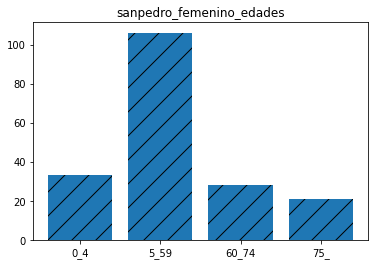

In [22]:
y = [sum_enf_4, sum_enf_59, sum_enf_74, sum_enf_120]
x = ['0_4', '5_59','60_74','75_']


plt.bar(x,y, hatch = '/')
plt.title("sanpedro_femenino_edades")
plt.savefig('C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos contaminantes/sanpedro/sanpedro_fem_edades.jpg')

In [19]:
sum_enf_4  = enf_filtro(path_enf,0,4,'2012/01/01','2016/12/31',98,db_date,'IJ','1.0')
sum_enf_59 = enf_filtro(path_enf,5,59,'2012/01/01','2016/12/31',98,db_date,'IJ','1.0')
sum_enf_74 = enf_filtro(path_enf,60,74,'2012/01/01','2016/12/31',98,db_date,'IJ','1.0')
sum_enf_120 = enf_filtro(path_enf,75,120,'2012/01/01','2016/12/31',98,db_date,'IJ','1.0')

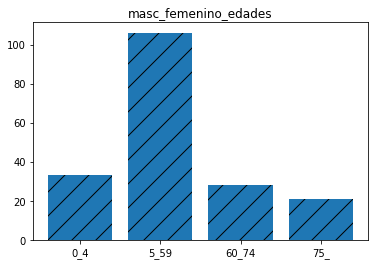

In [21]:
y = [sum_enf_4, sum_enf_59, sum_enf_74, sum_enf_120]
x = ['0_4', '5_59','60_74','75_']


plt.bar(x,y, hatch = '/')
plt.title("masc_femenino_edades")
plt.savefig('C:/Users/ASTRONAUTA/Documents/UNADM PROYECTO TERMINAL/datos contaminantes/sanpedro/sanpedro_masc_edades.jpg')

2012-01-01 00:00:00
2012-01-03 00:00:00
2012-01-03 00:00:00
2012-01-03 00:00:00
2012-01-03 00:00:00
2012-01-04 00:00:00
2012-01-05 00:00:00
2012-01-06 00:00:00
2012-01-14 00:00:00
2012-01-14 00:00:00
2012-01-15 00:00:00
2012-01-16 00:00:00
2012-01-16 00:00:00
2012-01-16 00:00:00
2012-01-18 00:00:00
2012-01-18 00:00:00
2012-01-18 00:00:00
2012-01-20 00:00:00
2012-01-21 00:00:00
2012-01-22 00:00:00
2012-01-22 00:00:00
2012-01-23 00:00:00
2012-01-23 00:00:00
2012-01-23 00:00:00
2012-01-24 00:00:00
2012-01-25 00:00:00
2012-01-25 00:00:00
2012-01-25 00:00:00
2012-01-25 00:00:00
2012-01-28 00:00:00
2012-01-28 00:00:00
2012-01-30 00:00:00
2012-01-31 00:00:00
2012-02-01 00:00:00
2012-02-01 00:00:00
2012-02-02 00:00:00
2012-02-02 00:00:00
2012-02-02 00:00:00
2012-02-02 00:00:00
2012-02-03 00:00:00
2012-02-03 00:00:00
2012-02-03 00:00:00
2012-02-04 00:00:00
2012-02-05 00:00:00
2012-02-05 00:00:00
2012-02-13 00:00:00
2012-02-15 00:00:00
2012-02-15 00:00:00
2012-02-15 00:00:00
2012-02-16 00:00:00


2013-10-22 00:00:00
2013-10-22 00:00:00
2013-10-23 00:00:00
2013-10-24 00:00:00
2013-10-24 00:00:00
2013-10-25 00:00:00
2013-10-25 00:00:00
2013-10-25 00:00:00
2013-10-25 00:00:00
2013-10-26 00:00:00
2013-10-26 00:00:00
2013-10-26 00:00:00
2013-10-26 00:00:00
2013-10-27 00:00:00
2013-10-27 00:00:00
2013-10-27 00:00:00
2013-10-28 00:00:00
2013-10-29 00:00:00
2013-10-29 00:00:00
2013-10-29 00:00:00
2013-10-29 00:00:00
2013-10-29 00:00:00
2013-10-30 00:00:00
2013-11-01 00:00:00
2013-11-01 00:00:00
2013-11-01 00:00:00
2013-11-02 00:00:00
2013-11-02 00:00:00
2013-11-02 00:00:00
2013-11-03 00:00:00
2013-11-03 00:00:00
2013-11-03 00:00:00
2013-11-04 00:00:00
2013-11-04 00:00:00
2013-11-05 00:00:00
2013-11-06 00:00:00
2013-11-06 00:00:00
2013-11-06 00:00:00
2013-11-07 00:00:00
2013-11-07 00:00:00
2013-11-07 00:00:00
2013-11-09 00:00:00
2013-11-09 00:00:00
2013-11-10 00:00:00
2013-11-10 00:00:00
2013-11-11 00:00:00
2013-11-11 00:00:00
2013-11-12 00:00:00
2013-11-12 00:00:00
2013-11-13 00:00:00


2015-11-18 00:00:00
2015-11-18 00:00:00
2015-11-18 00:00:00
2015-11-18 00:00:00
2015-11-18 00:00:00
2015-11-18 00:00:00
2015-11-19 00:00:00
2015-11-19 00:00:00
2015-11-19 00:00:00
2015-11-20 00:00:00
2015-11-20 00:00:00
2015-11-21 00:00:00
2015-11-21 00:00:00
2015-11-23 00:00:00
2015-11-23 00:00:00
2015-11-24 00:00:00
2015-11-24 00:00:00
2015-11-25 00:00:00
2015-11-25 00:00:00
2015-11-25 00:00:00
2015-11-25 00:00:00
2015-11-27 00:00:00
2015-11-28 00:00:00
2015-11-28 00:00:00
2015-11-29 00:00:00
2015-11-30 00:00:00
2015-12-01 00:00:00
2015-12-01 00:00:00
2015-12-01 00:00:00
2015-12-03 00:00:00
2015-12-03 00:00:00
2015-12-03 00:00:00
2015-12-04 00:00:00
2015-12-05 00:00:00
2015-12-05 00:00:00
2015-12-06 00:00:00
2015-12-06 00:00:00
2015-12-08 00:00:00
2015-12-11 00:00:00
2015-12-14 00:00:00
2015-12-15 00:00:00
2015-12-15 00:00:00
2015-12-15 00:00:00
2015-12-15 00:00:00
2015-12-15 00:00:00
2015-12-15 00:00:00
2015-12-16 00:00:00
2015-12-18 00:00:00
2015-12-19 00:00:00
2015-12-24 00:00:00


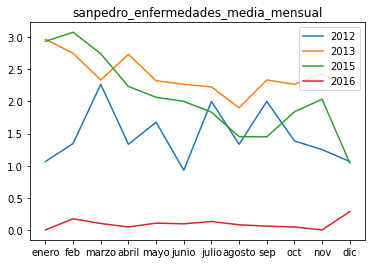

In [49]:
sum_enf_4,lenf = enf_filtro(path_enf,0,70,'2012/01/01','2012/12/31',98,db_date,'IJ','non')
ciclo_enf(lenf,'2012')
sum_enf_4,lenf = enf_filtro(path_enf,0,120,'2013/01/01','2013/12/31',98,db_date,'IJ','non')
ciclo_enf(lenf,'2013')
sum_enf_4,lenf = enf_filtro(path_enf,0,120,'2015/01/01','2015/12/31',98,db_date,'IJ','non')
ciclo_enf(lenf,'2015')
sum_enf_4,lenf = enf_filtro(path_enf,0,120,'2016/01/01','2016/12/31',98,db_date,'IJ','non')
lenf.insert(0,0)
lenf.insert(10,0)
ciclo_enf(lenf,'2016')

In [38]:
lista_enf = enfermedades_filtro(path_enf,0,120,'2016/01/01','2016/12/31',98,'date16',db_date,'IJ')

date16
342
0.05555555555555555
lista enfermedades: 366


In [26]:
sum_enf_4,lenf = enf_filtro(path_enf,0,120,'2016/01/01','2016/12/31',98,db_date,'IJ','non')

2016-02-11 00:00:00
2016-02-15 00:00:00
2016-02-20 00:00:00
2016-02-23 00:00:00
2016-03-19 00:00:00
2016-03-28 00:00:00
2016-03-30 00:00:00
2016-04-22 00:00:00
2016-05-03 00:00:00
2016-05-19 00:00:00
2016-06-20 00:00:00
2016-06-21 00:00:00
2016-07-02 00:00:00
2016-07-19 00:00:00
2016-07-23 00:00:00
2016-08-19 00:00:00
2016-08-25 00:00:00
2016-09-17 00:00:00
2016-10-22 00:00:00
2016-12-07 00:00:00


In [41]:
lenf.insert(0,0)

In [47]:
lenf.insert(10,0)

In [48]:
lenf

[0,
 0.17391304347826086,
 0.1,
 0.045454545454545456,
 0.10526315789473684,
 0.09523809523809523,
 0.13043478260869565,
 0.08,
 0.058823529411764705,
 0.045454545454545456,
 0,
 0.2857142857142857]